In [1]:
from tensorflow import keras

from tensorflow.keras import models, layers 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 

In [13]:
# h0 = 67,45
# omega_m = 0.315

In [2]:
# Preparing the dataset and creating the features and target arrays

n_sims = 10000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
    data = np.load(f'input/data_{i+1}.npy')
    x.append(data[:, :2])
    y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

norm = y.max()
# Normalização
y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 10000/10000 [00:03<00:00, 3110.53it/s]


In [62]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    patience=5,          
    verbose=1,          
    factor=0.5,          
    min_lr=0.00001       
)

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=5,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

lr_callback = keras.callbacks.LearningRateScheduler(learning_rate_schedule)


In [63]:
# defining the model


model = models.Sequential()

model.add(layers.GRU(32,input_shape=(80,2)))

model.add(layers.Flatten())

model.add(layers.Dense(16))
model.add(layers.Dropout(.3))

model.add(layers.Dense(1))

model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam', metrics=keras.metrics.MeanAbsoluteError())


history = model.fit(x_train, y_train, validation_split=.1, epochs=20, batch_size=16, verbose=1, callbacks=[lr_callback])

Epoch 1/20
422/422 [==============================] - 7s 13ms/step - loss: 0.0422 - mean_absolute_error: 0.1394 - val_loss: 0.0019 - val_mean_absolute_error: 0.0370 - lr: 0.0100
Epoch 2/20
422/422 [==============================] - 5s 13ms/step - loss: 0.0064 - mean_absolute_error: 0.0619 - val_loss: 0.0027 - val_mean_absolute_error: 0.0415 - lr: 0.0087
Epoch 3/20
422/422 [==============================] - 5s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0289 - val_loss: 1.3431e-04 - val_mean_absolute_error: 0.0099 - lr: 0.0076
Epoch 4/20
422/422 [==============================] - 5s 13ms/step - loss: 4.1210e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0013 - val_mean_absolute_error: 0.0351 - lr: 0.0066
Epoch 5/20
422/422 [==============================] - 5s 12ms/step - loss: 2.4708e-04 - mean_absolute_error: 0.0121 - val_loss: 7.9274e-05 - val_mean_absolute_error: 0.0071 - lr: 0.0057
Epoch 6/20
422/422 [==============================] - 6s 13ms/step - loss: 1.7530e-04 - mean_a

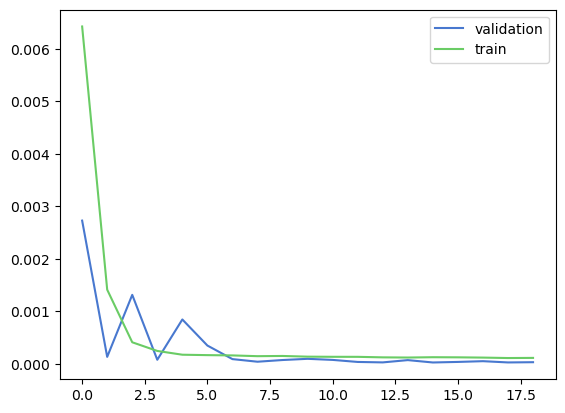

In [71]:
plt.plot(history.history['val_loss'][1:], label='validation')
plt.plot(history.history['loss'][1:], label='train')

plt.legend()
plt.show()

Dummy variables just for visualization purposes

In [65]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)


79/79 [==============================] - 1s 4ms/step


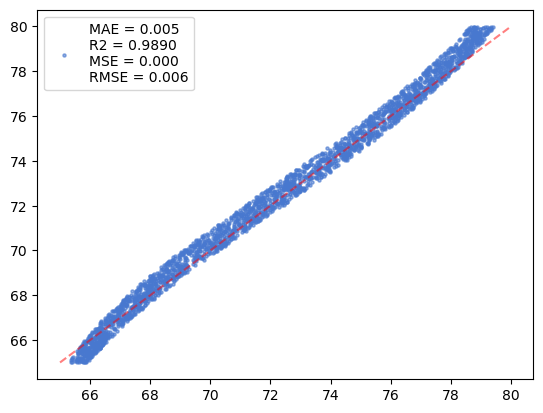

In [66]:
plt.style.use('seaborn-v0_8-muted')

# linha = np.linspace(.3, .35, 2500)
linha = np.linspace(65, 80)


plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'MAE = {mae:.3f}\nR2 = {r2:.4f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()
plt.savefig("imagens/metrics_h0_rnn")
plt.show()

In [67]:
# forecasting "real" H(0)

real = np.load('input/data_real80.npy')
real = real[real[:, 1].argsort()]

real = real.reshape(-1,80,2)

In [68]:

final_real = model.predict(real, verbose=0)

In [69]:
final_real*norm

array([[67.28079]], dtype=float32)

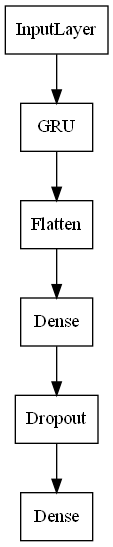

In [70]:
keras.utils.plot_model(model, to_file='imagens/model_rnn.png', show_shapes=False, show_layer_names=False)


In [73]:
model.save('models/rnn')

INFO:tensorflow:Assets written to: models/rnn\assets


INFO:tensorflow:Assets written to: models/rnn\assets
